In [1]:
!pip install pingouin

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
from IPython.display import display, HTML

IMPORT DATA

In [41]:
# Load the data with the specific file path and sheet name
file_path = "Dataset_alpha.xlsx"
sheet_name = "C_H_A_BG"

# Load the data
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows
print("Original Data Preview:")
display(df.head())

Original Data Preview:


,C_R_F_E,C_R_F_I,C_R_C_E,C_R_C_I,C_R_T_E,C_R_T_I,C_R_P_E,C_R_P_I,C_R_O_E,C_R_O_I,...,U_L_F_E,U_L_F_I,U_L_C_E,U_L_C_I,U_L_T_E,U_L_T_I,U_L_P_E,U_L_P_I,U_L_O_E,U_L_O_I
0,0.003054,0.004289,0.061479,-0.136322,0.027087,-0.133538,0.193271,-0.162234,0.051761,-0.315130,...,0.033742,0.090182,0.144715,-0.035038,0.257621,-0.028512,0.221089,-0.166383,0.233743,0.142857
1,-0.110261,-0.344977,-0.240889,-0.408116,-0.090488,-0.578716,-0.208294,-0.551228,-0.048350,-0.501287,...,0.186466,0.046064,0.087381,0.205410,0.019182,0.163885,-0.053254,0.238283,-0.072507,-0.013074
2,-0.091700,-0.396313,-0.248986,-0.341770,0.027431,-0.143739,-0.167974,-0.087454,-0.007014,-0.023580,...,-0.191635,0.078331,-0.125315,0.336780,-0.113322,0.362627,-0.027330,0.251417,0.065871,0.114666
3,0.032422,0.260445,-0.078025,0.253060,-0.049401,0.092914,-0.081762,0.153670,-0.055963,0.136259,...,-0.090193,-0.237667,-0.231297,-0.168512,-0.379166,0.024634,-0.523421,0.022479,-0.784738,0.215033
4,-0.005794,0.259992,-0.212096,0.295015,-0.268128,-0.391975,-0.244265,-0.382255,-0.043667,-0.655092,...,-0.073387,0.077022,-0.158665,0.172163,-0.147307,0.182365,-0.169967,0.149199,-0.134386,-0.023841


In [42]:
# Reshape the data: Convert wide format to long format
df_long = df.melt(var_name="Factor_Combination", value_name="Value")

# Extract factor levels from column names
df_long[['Condition', 'Hemisphere', 'Area', 'Background']] = df_long['Factor_Combination'].str.split('_', expand=True)

# Drop the original column name field
df_long.drop(columns=['Factor_Combination'], inplace=True)

# Convert categorical variables
df_long['Condition'] = df_long['Condition'].map({'C': 'Convergent', 'U': 'Divergent'})
df_long['Hemisphere'] = df_long['Hemisphere'].map({'R': 'Right', 'L': 'Left'})
df_long['Area'] = df_long['Area'].map({'F': 'Frontal', 'C': 'Central', 'T': 'Temporal', 'P': 'Parietal', 'O': 'Occipital'})
df_long['Background'] = df_long['Background'].map({'E': 'EDs', 'I': 'IDEs'})

# Display the transformed dataset
df_long.head()

,Value,Condition,Hemisphere,Area,Background
0,0.003054,Convergent,Right,Frontal,EDs
1,-0.110261,Convergent,Right,Frontal,EDs
2,-0.091700,Convergent,Right,Frontal,EDs
3,0.032422,Convergent,Right,Frontal,EDs
4,-0.005794,Convergent,Right,Frontal,EDs


In [43]:
# Check missing values by each combination of factors
missing_by_combination = df_long[df_long['Value'].isna()]
print(missing_by_combination.groupby(['Condition', 'Hemisphere', 'Area', 'Background']).size())

Condition   Hemisphere  Area       Background
Convergent  Left        Central    EDs            71
                                   IDEs          143
                        Frontal    EDs            71
                                   IDEs          143
                        Occipital  EDs            71
                                   IDEs          143
                        Parietal   EDs            71
                                   IDEs          143
                        Temporal   EDs            71
                                   IDEs          143
            Right       Central    EDs            71
                                   IDEs          143
                        Frontal    EDs            71
                                   IDEs          143
                        Occipital  EDs            71
                                   IDEs          143
                        Parietal   EDs            71
                                   IDEs          143


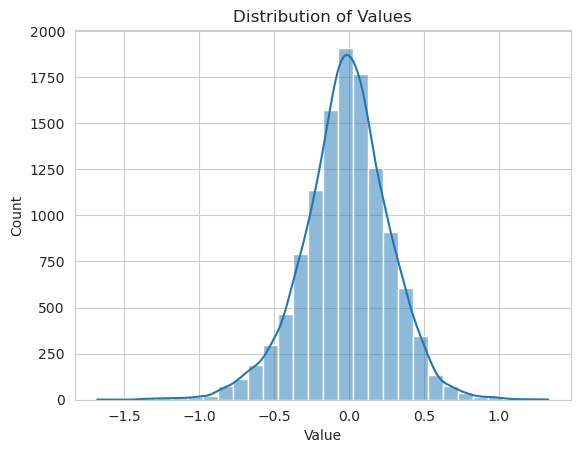

In [44]:
sns.histplot(df_long['Value'], bins=30, kde=True)
plt.title("Distribution of Values")
plt.show()

In [45]:
# Check the number of occurrences for each combination of factors
factor_counts = df_long.groupby(['Condition', 'Hemisphere', 'Area', 'Background']).size().reset_index(name='Counts')

# Display combinations with no data
empty_combinations = factor_counts[factor_counts['Counts'] == 0]
print(empty_combinations)

Empty DataFrame
Columns: [Condition, Hemisphere, Area, Background, Counts]
Index: []


In [46]:
# Remove rows with missing values
df_long_clean = df_long.dropna(subset=['Condition', 'Hemisphere', 'Area', 'Background', 'Value'])

In [47]:
print(df_long.head())

      Value   Condition Hemisphere     Area Background
0  0.003054  Convergent      Right  Frontal        EDs
1 -0.110261  Convergent      Right  Frontal        EDs
2 -0.091700  Convergent      Right  Frontal        EDs
3  0.032422  Convergent      Right  Frontal        EDs
4 -0.005794  Convergent      Right  Frontal        EDs


In [48]:
print(df_long['Value'].isna().sum())

3150


In [49]:
group_sizes = df_long.groupby(['Condition', 'Hemisphere', 'Area', 'Background']).size().reset_index(name='Sample_Count')
print(group_sizes)

     Condition Hemisphere       Area Background  Sample_Count
0   Convergent       Left    Central        EDs           373
1   Convergent       Left    Central       IDEs           373
2   Convergent       Left    Frontal        EDs           373
3   Convergent       Left    Frontal       IDEs           373
4   Convergent       Left  Occipital        EDs           373
5   Convergent       Left  Occipital       IDEs           373
6   Convergent       Left   Parietal        EDs           373
7   Convergent       Left   Parietal       IDEs           373
8   Convergent       Left   Temporal        EDs           373
9   Convergent       Left   Temporal       IDEs           373
10  Convergent      Right    Central        EDs           373
11  Convergent      Right    Central       IDEs           373
12  Convergent      Right    Frontal        EDs           373
13  Convergent      Right    Frontal       IDEs           373
14  Convergent      Right  Occipital        EDs           373
15  Conv

In [50]:
# Re-run the ANOVA test
anova_results = pg.anova(
    dv="Value",
    between=["Condition", "Hemisphere", "Area", "Background"],
    data=df_long_clean,
    detailed=True
)

# Display results
print(anova_results)

                                        Source          SS       DF        MS  \
0                                    Condition    8.388324      1.0  8.388324   
1                                   Hemisphere    1.968730      1.0  1.968730   
2                                         Area    2.467369      4.0  0.616842   
3                                   Background    4.270755      1.0  4.270755   
4                       Condition * Hemisphere    0.006923      1.0  0.006923   
5                             Condition * Area    1.128936      4.0  0.282234   
6                            Hemisphere * Area    1.263601      4.0  0.315900   
7                       Condition * Background    0.978439      1.0  0.978439   
8                      Hemisphere * Background    0.004270      1.0  0.004270   
9                            Area * Background    0.143645      4.0  0.035911   
10               Condition * Hemisphere * Area    0.034802      4.0  0.008700   
11         Condition * Hemis

In [51]:
anova_results['Effect Size (η²)'] = anova_results['SS'] / anova_results['SS'].sum()
display(anova_results)

,Source,SS,DF,MS,F,p-unc,np2,Effect Size (η²)
0,Condition,8.388324,1.0,8.388324,100.835620,1.245029e-23,0.008523,0.008416
1,Hemisphere,1.968730,1.0,1.968730,23.666004,1.160782e-06,0.002013,0.001975
2,Area,2.467369,4.0,0.616842,7.415031,5.834054e-06,0.002522,0.002475
3,Background,4.270755,1.0,4.270755,51.338537,8.239093e-13,0.004358,0.004285
4,Condition * Hemisphere,0.006923,1.0,0.006923,0.083221,7.729841e-01,0.000007,0.000007
5,Condition * Area,1.128936,4.0,0.282234,3.392722,8.824057e-03,0.001156,0.001133
6,Hemisphere * Area,1.263601,4.0,0.315900,3.797421,4.339874e-03,0.001293,0.001268
7,Condition * Background,0.978439,1.0,0.978439,11.761764,6.066793e-04,0.001002,0.000982
8,Hemisphere * Background,0.004270,1.0,0.004270,0.051331,8.207668e-01,0.000004,0.000004
9,Area * Background,0.143645,4.0,0.035911,0.431687,7.858496e-01,0.000147,0.000144


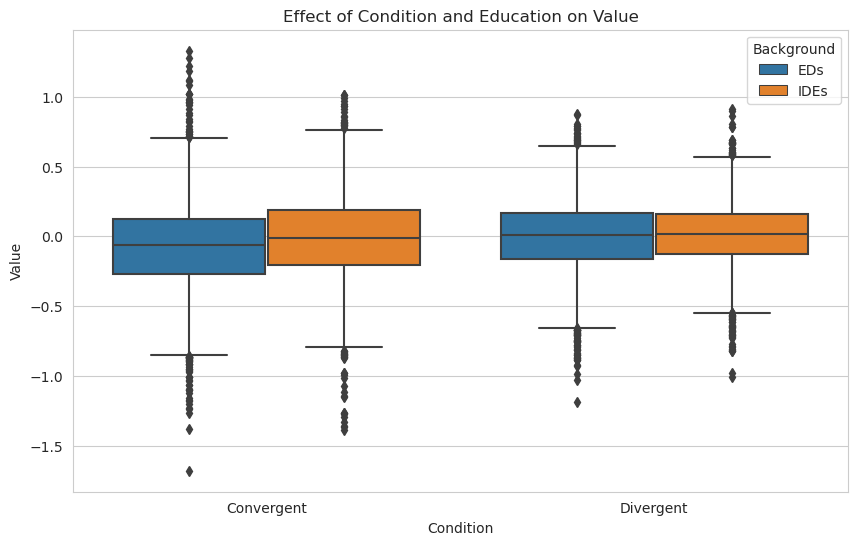

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Condition", y="Value", hue="Background", data=df_long)
plt.title("Effect of Condition and Education on Value")
plt.show()

In [53]:
import pingouin as pg

# List of factors
factors = ['Condition', 'Hemisphere', 'Area', 'Background']

# Run Tukey post-hoc test for each factor
posthoc_results = {}
for factor in factors:
    posthoc = pg.pairwise_tukey(
        data=df_long, 
        dv="Value", 
        between=[factor]
    )
    posthoc_results[factor] = posthoc
    display(posthoc)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Convergent,Divergent,-0.049009,0.004225,-0.053234,0.005367,-9.918069,3.032685e-12,-0.183676


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Left,Right,-0.006904,-0.03277,0.025866,0.00536,4.826204,0.000001,0.088965


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Central,Frontal,-0.014663,0.000605,-0.015268,0.008473,-1.801938,0.372399,-0.057129
1,Central,Occipital,-0.014663,-0.036809,0.022145,0.008473,2.613549,0.067954,0.074320
2,Central,Parietal,-0.014663,-0.035952,0.021288,0.008473,2.512415,0.087905,0.070865
3,Central,Temporal,-0.014663,-0.012366,-0.002298,0.008473,-0.271201,0.998815,-0.008035
4,Frontal,Occipital,0.000605,-0.036809,0.037413,0.008473,4.415487,0.000099,0.132614
5,Frontal,Parietal,0.000605,-0.035952,0.036556,0.008473,4.314352,0.000157,0.128406
6,Frontal,Temporal,0.000605,-0.012366,0.012970,0.008473,1.530736,0.542371,0.048135
7,Occipital,Parietal,-0.036809,-0.035952,-0.000857,0.008473,-0.101134,0.999976,-0.002732
8,Occipital,Temporal,-0.036809,-0.012366,-0.024443,0.008473,-2.884751,0.032065,-0.081493
9,Parietal,Temporal,-0.035952,-0.012366,-0.023586,0.008473,-2.783616,0.042866,-0.078007


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,EDs,IDEs,-0.036019,0.001922,-0.037941,0.005412,-7.009838,5.549117e-12,-0.130637


<Figure size 1500x1000 with 0 Axes>

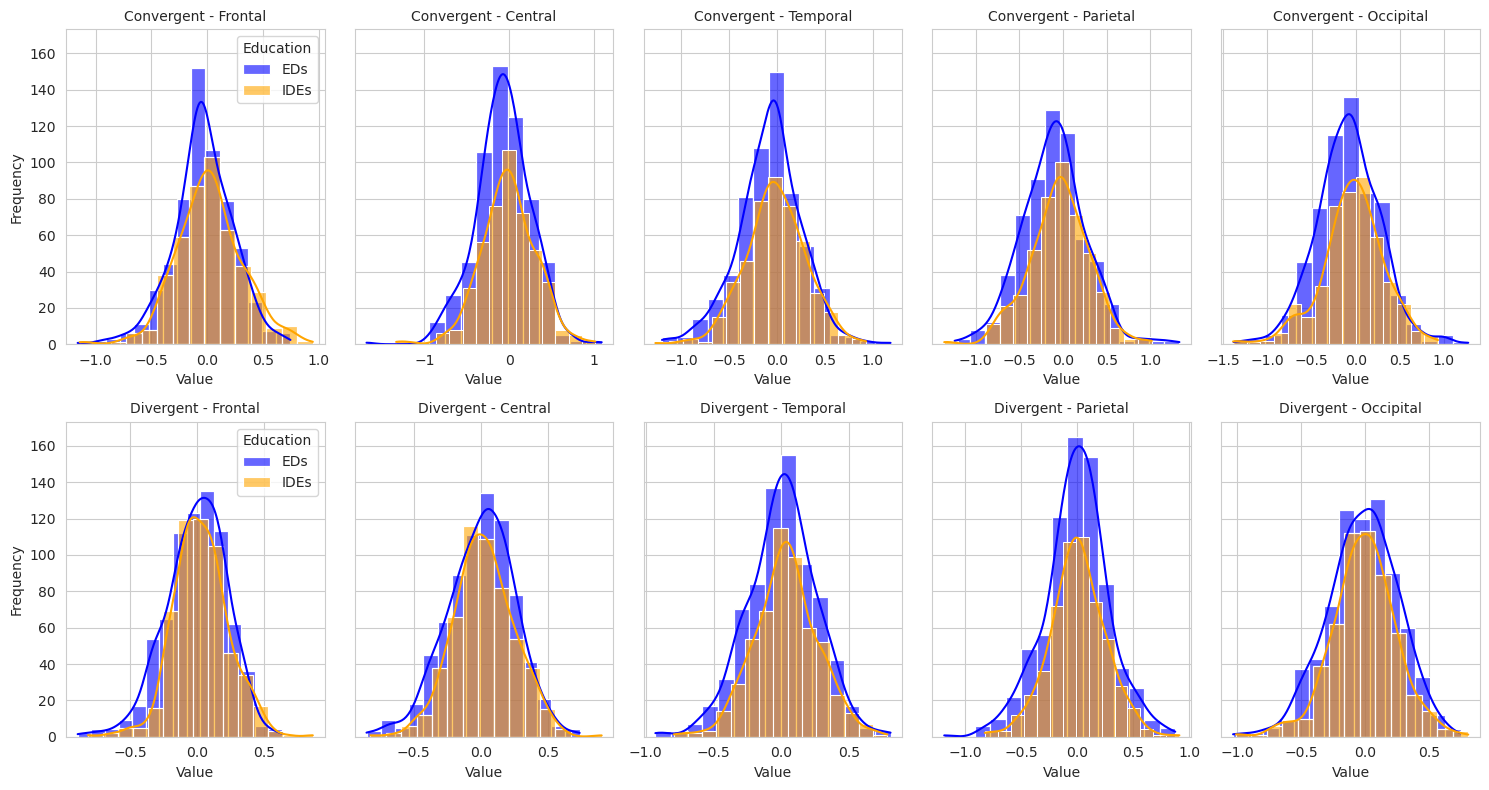

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size and style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# Define colors for Education backgrounds
education_colors = {"EDs": "blue", "IDEs": "orange"}

# Get unique conditions
conditions = df_long["Condition"].unique()
areas = df_long["Area"].unique()

# Create subplots: One row per condition
fig, axes = plt.subplots(nrows=len(conditions), ncols=len(areas), figsize=(15, 8), sharey=True)

# Loop through conditions and areas to create paired histograms
for row_idx, condition in enumerate(conditions):
    for col_idx, area in enumerate(areas):
        ax = axes[row_idx, col_idx]  # Get subplot
        
        # Filter data for this condition and area
        subset = df_long[(df_long["Condition"] == condition) & (df_long["Area"] == area)]
        
        # Plot histograms for both education backgrounds
        for education in education_colors.keys():
            sns.histplot(
                subset[subset["Background"] == education]["Value"],
                bins=15,
                kde=True,
                color=education_colors[education],
                label=education,
                alpha=0.6,
                ax=ax
            )

        # Titles and labels
        ax.set_title(f"{condition} - {area}", fontsize=10)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

        # Add legend only for the first subplot in each row
        if col_idx == 0:
            ax.legend(title="Education")

# Adjust layout
plt.tight_layout()
plt.show()

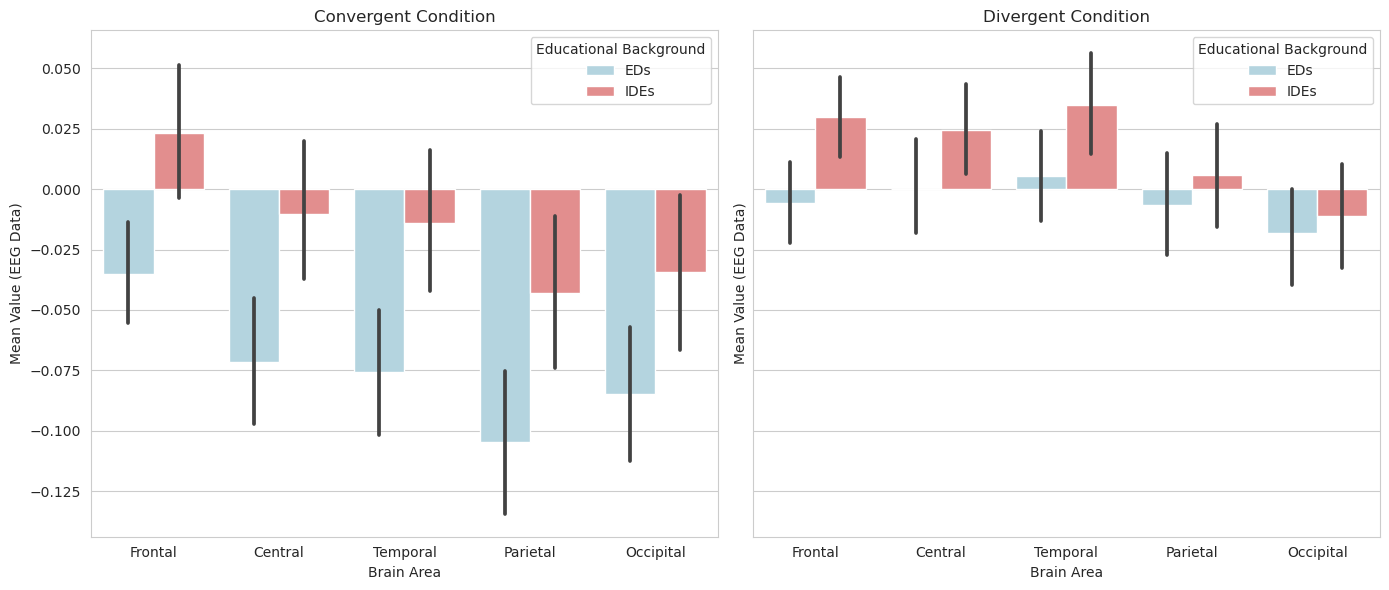

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# Define soft pastel colors for Education backgrounds
education_colors = {"EDs": "lightblue", "IDEs": "lightcoral"}

# Get unique conditions and areas
conditions = df_long["Condition"].unique()
areas = df_long["Area"].unique()

# Create subplots: One for each condition
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

for idx, condition in enumerate(conditions):
    ax = axes[idx]  # Select subplot
    
    # Filter data for this condition
    subset = df_long[df_long["Condition"] == condition]
    
    # Create a bar plot (grouped by Area, colored by Education)
    sns.barplot(
        data=subset,
        x="Area",
        y="Value",
        hue="Background",
        palette=education_colors,
        dodge=True,  # Ensures bars are side-by-side, not stacked
        ax=ax
    )
    
    # Titles and labels
    ax.set_title(f"{condition} Condition", fontsize=12)
    ax.set_xlabel("Brain Area")
    ax.set_ylabel("Mean Value (EEG Data)")
    ax.legend(title="Educational Background")

# Save the plot with soft colors as an image file
plt.savefig("Alpha_TRPs_by_Area-coloured-soft.png", dpi=300)

# Adjust layout and display
plt.tight_layout()
plt.show()

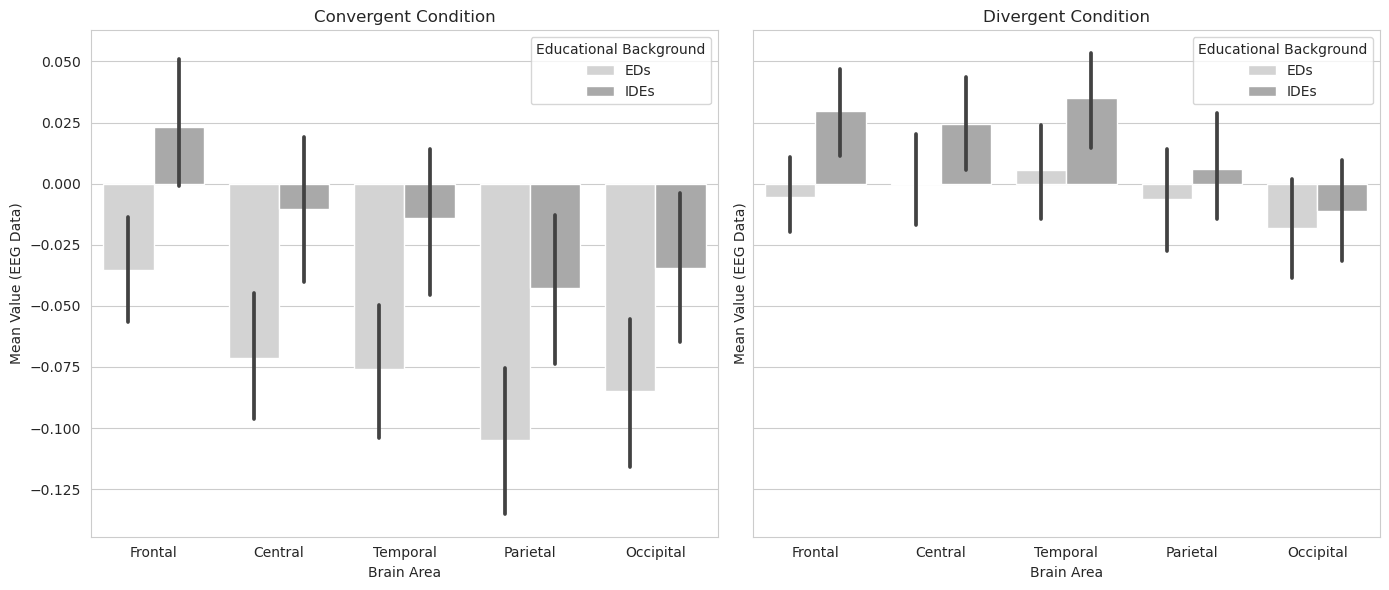

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# Define grayscale colors for Education backgrounds (using light grey for "EDs" and dark grey for "IDEs")
education_colors = {"EDs": "lightgrey", "IDEs": "darkgrey"}

# Get unique conditions and areas
conditions = df_long["Condition"].unique()
areas = df_long["Area"].unique()

# Create subplots: One for each condition
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

for idx, condition in enumerate(conditions):
    ax = axes[idx]  # Select subplot
    
    # Filter data for this condition
    subset = df_long[df_long["Condition"] == condition]
    
    # Create a bar plot (grouped by Area, colored by Education in grayscale)
    sns.barplot(
        data=subset,
        x="Area",
        y="Value",
        hue="Background",
        palette=education_colors,
        dodge=True,  # Ensures bars are side-by-side, not stacked
        ax=ax
    )
    
    # Titles and labels
    ax.set_title(f"{condition} Condition", fontsize=12)
    ax.set_xlabel("Brain Area")
    ax.set_ylabel("Mean Value (EEG Data)")
    ax.legend(title="Educational Background")

plt.savefig("Alpha_TRPs_by_Area_greyScale.png", dpi=300)

# Adjust layout and display
plt.tight_layout()
plt.show()

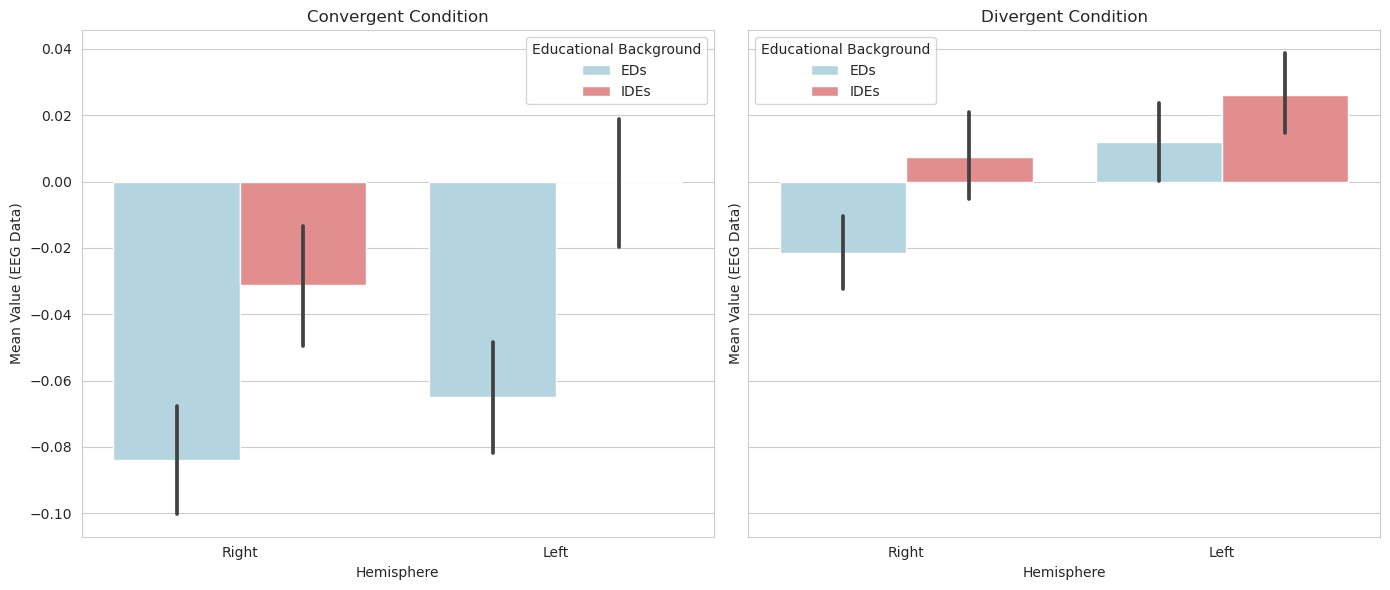

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# Define soft pastel colors for Education backgrounds
education_colors = {"EDs": "lightblue", "IDEs": "lightcoral"}

# Get unique conditions
conditions = df_long["Condition"].unique()

# Create subplots: One for each condition
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

for idx, condition in enumerate(conditions):
    ax = axes[idx]  # Select subplot
    
    # Filter data for this condition
    subset = df_long[df_long["Condition"] == condition]
    
    # Create a bar plot (grouped by Hemisphere, colored by Education)
    sns.barplot(
        data=subset,
        x="Hemisphere",
        y="Value",
        hue="Background",
        palette=education_colors,
        dodge=True,  # Ensures bars are side-by-side, not stacked
        ax=ax
    )
    
    # Titles and labels
    ax.set_title(f"{condition} Condition", fontsize=12)
    ax.set_xlabel("Hemisphere")
    ax.set_ylabel("Mean Value (EEG Data)")
    ax.legend(title="Educational Background")

# Save the plot with hemisphere on the x-axis as an image file
plt.savefig("Alpha_TRPs_by_Hemisphere-coloured-soft.png", dpi=300)

# Adjust layout and display
plt.tight_layout()
plt.show()

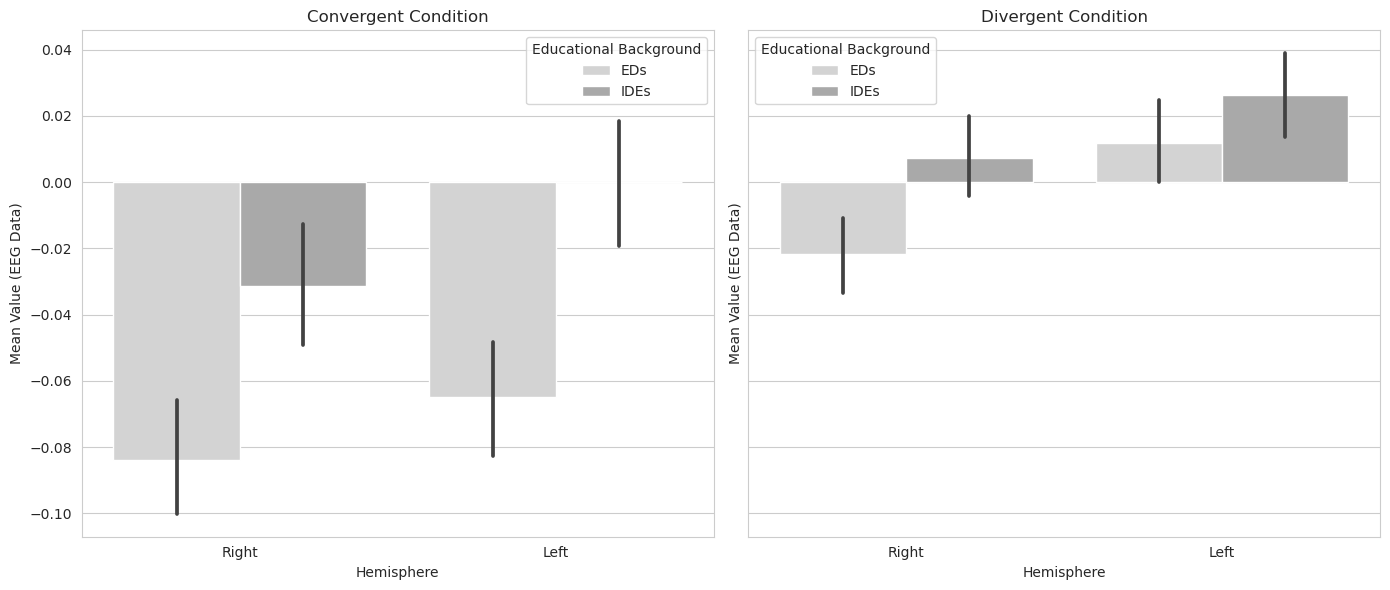

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# Define grey scale colors for Education backgrounds
education_colors = {"EDs": "lightgrey", "IDEs": "darkgrey"}

# Get unique conditions
conditions = df_long["Condition"].unique()

# Create subplots: One for each condition
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

for idx, condition in enumerate(conditions):
    ax = axes[idx]  # Select subplot
    
    # Filter data for this condition
    subset = df_long[df_long["Condition"] == condition]
    
    # Create a bar plot (grouped by Hemisphere, colored by Education)
    sns.barplot(
        data=subset,
        x="Hemisphere",
        y="Value",
        hue="Background",
        palette=education_colors,
        dodge=True,  # Ensures bars are side-by-side, not stacked
        ax=ax
    )
    
    # Titles and labels
    ax.set_title(f"{condition} Condition", fontsize=12)
    ax.set_xlabel("Hemisphere")
    ax.set_ylabel("Mean Value (EEG Data)")
    ax.legend(title="Educational Background")

# Save the plot with hemisphere on the x-axis as an image file
plt.savefig("Alpha_TRPs_by_Hemisphere-grayscale.png", dpi=300)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [39]:
# Check missing values in 'Value' after reshaping
print(df_long['Value'].isna().sum())

3150


In [41]:
# Drop the imbalanced group 'Divergent - Right - Temporal'
df_long_clean = df_long[~((df_long['Condition'] == 'Divergent') & (df_long['Hemisphere'] == 'Right') & (df_long['Area'] == 'Temporal'))]

# Check group sizes after removal
print(df_long_clean.groupby(['Condition', 'Education', 'Hemisphere', 'Area']).size())

Condition   Education    Hemisphere  Area     
Convergent  Engineers    Left        Central      373
                                     Frontal      373
                                     Occipital    373
                                     Parietal     373
                                     Temporal     373
                         Right       Central      373
                                     Frontal      373
                                     Occipital    373
                                     Parietal     373
                                     Temporal     373
            Industrials  Left        Central      373
                                     Frontal      373
                                     Occipital    373
                                     Parietal     373
                                     Temporal     373
                         Right       Central      373
                                     Frontal      373
                                   